<참조 : https://www.tensorflow.org/tutorials/load_data/images>

## 이미지 로드

### 01. 설정

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.5.0


#### 01. 01. 꽃 데이터세트 다운로드
  - flowers_photos
    - daisy
    - dandelion
    - roses
    - sunflows
    - tulips  
      
        
        
  - 모든 이미지에는 CC-BY 라이선스가 있습니다.
    - 크리에이터 : LICENSE.txt 파일에 나열

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


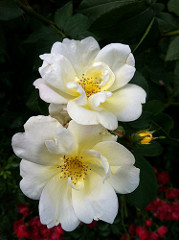

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

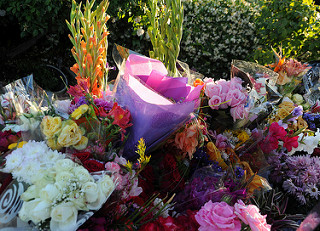

In [6]:
roses = list(data_dir.glob('roses/*'))
# for i in range(10, 15):
PIL.Image.open(str(roses[3]))

### 02. keras.preprocessing을 사용하여 로드

#### 02. 01. 데이터세트 만들기

In [7]:
batch_size = 32
img_height = 180
img_width = 180

#### 검증분할
  - 훈련이미지 : 80% 사용
  - 검증 : 20% 사용

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### 02. 02. 데이터 시각화하기

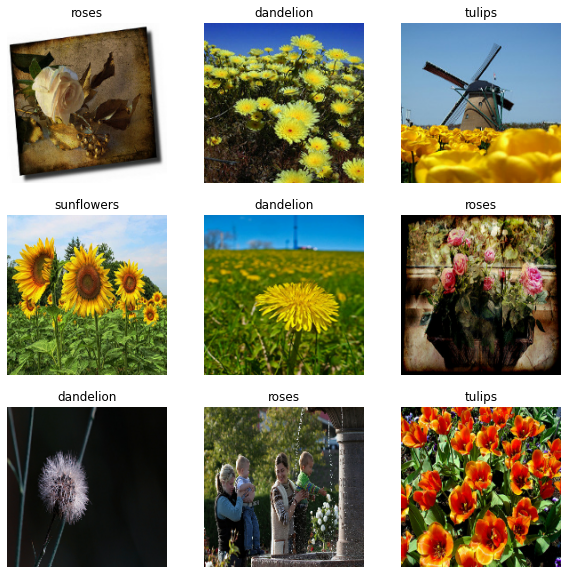

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


- 32 : batch_size
- 188 * 180 : height * width
- 3 : color

#### 02. 03. 데이터 표준화하기
  - RGB 채널 값 : 0~255
    - 신경망에는 이상적이지 않음
    - Rescaling 레이어를 사용하여 [0, 1] 에 있도록 표준화  
      
    - Rescaling(1./(255/2), offset=-1) : 값이 [-1, 1]

In [13]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in '[0, 1]'.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


#### 02. 04 성능을 위한 데이터세트구성
  - 버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다
    - .cache() : 첫 번째 에포크 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다
      - 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다
      - 성능이 높은 온디스크 캐시를 생성할 수 있습니다  
        
    - .prefetch() : 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 02. 05.  모델 훈련하기

In [16]:
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [18]:
model.fit(train_ds,
         batch_size=batch_size,
         validation_data=val_ds,
         epochs=3)

Epoch 1/3
92/92 [==============================] - 268s 3s/step - loss: 1.3224 - accuracy: 0.4407 - val_loss: 1.1111 - val_accuracy: 0.5790
Epoch 2/3
92/92 [==============================] - 253s 3s/step - loss: 1.0501 - accuracy: 0.5841 - val_loss: 1.0157 - val_accuracy: 0.6226
Epoch 3/3
92/92 [==============================] - 265s 3s/step - loss: 0.8784 - accuracy: 0.6621 - val_loss: 0.9512 - val_accuracy: 0.6403


### 03. 미세 제어를 위해 tf.data 사용하기

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\jjanh_000\\.keras\\datasets\\flower_photos\\sunflowers\\15054866898_60ee50ec6b_n.jpg'
b'C:\\Users\\jjanh_000\\.keras\\datasets\\flower_photos\\daisy\\9529916092_de70623523_n.jpg'
b'C:\\Users\\jjanh_000\\.keras\\datasets\\flower_photos\\dandelion\\18876985840_7531dc8e6a.jpg'
b'C:\\Users\\jjanh_000\\.keras\\datasets\\flower_photos\\daisy\\14600779226_7bbc288d40_m.jpg'
b'C:\\Users\\jjanh_000\\.keras\\datasets\\flower_photos\\sunflowers\\3154932290_4bf43bd34f_n.jpg'


In [21]:
# 파일의 트리구조를 사용하여 class_names 목록을 컴파일할 수 있습니다

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [24]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    
    # Integer encode the label
    return tf.argmax(one_hot)

In [25]:
def decode_img(img):
    #convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
#     img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [27]:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  4


#### 03. 01. 성능을 위한 데이터세트 구성하기
  - 잘 섞는다
  - 배치 처리한다
  - 가능한 빨리 배치를 사용할 수 있어야 한다

In [31]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [32]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

#### 03. 02. 데이터 시각화하기

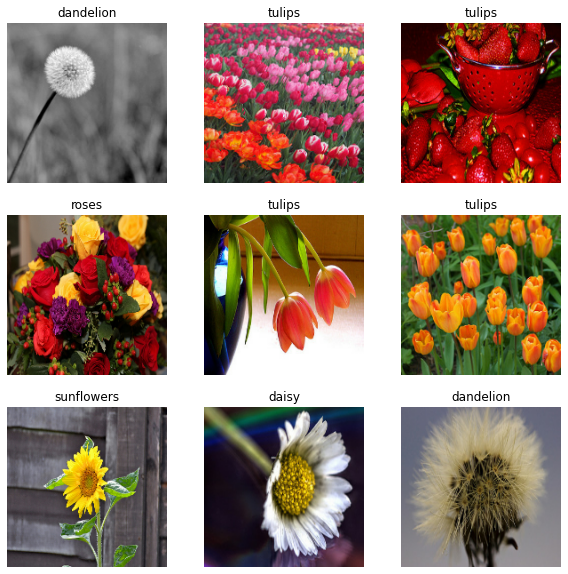

In [33]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

#### 03. 03. 모델 계속 훈련하기

In [35]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 275s 3s/step - loss: 0.7305 - accuracy: 0.7262 - val_loss: 0.7714 - val_accuracy: 0.7084
Epoch 2/3
92/92 [==============================] - 266s 3s/step - loss: 0.5743 - accuracy: 0.7926 - val_loss: 0.9146 - val_accuracy: 0.6512
Epoch 3/3
92/92 [==============================] - 293s 3s/step - loss: 0.4114 - accuracy: 0.8549 - val_loss: 0.7611 - val_accuracy: 0.7302


### 04. TensorFlow 데이터세트 사용하기

In [36]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:01, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\jjanh_000\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [37]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


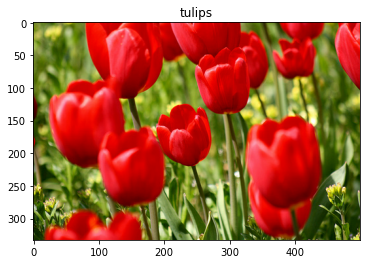

In [38]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [39]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)